# Kinetic analysis notebook

In [41]:
import io
import re
import glob
import datetime
import warnings #useful for having cleaner outputs that get rolled into .md files
from functools import partial

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


## Load Platemap

In [42]:
# These should be rolled into a library

def read_platemap_tsv(platemap_path: str) -> pd.DataFrame:
    platemap = pd.read_table(platemap_path)

    platemap["Row"] = platemap["Well"].apply(lambda s: re.search(r"[A-Z]", s).group())
    platemap["Column"] = platemap["Well"].apply(lambda s: int(re.search(r"\d+", s).group()))
    platemap["Column"] = platemap["Column"].astype(int)

    return platemap

def read_platemap_str(platemap_str: str) -> pd.DataFrame:
    platemap = pd.read_table(io.StringIO(platemap_str), index_col=0)
    print(platemap)
    platemap.index.name = "Row"
    platemap = platemap.reset_index().melt(id_vars=["Row"], var_name="Column", value_name="Construct")
    
    platemap["Column"] = platemap["Column"].astype(int)
    platemap["Well"] = platemap.apply(lambda well: f"{well['Row']}:{well['Column']}", axis=1)
    platemap = platemap.rename(columns={"Construct": "Label"})
    platemap = platemap.dropna()
    return platemap

def read_platemap_excel(platemap_path: str) -> pd.DataFrame:
    """
    Use like this:

    
    > platemap_path = "bnext/experiments/20240703-PURE-pT7deGFP-tetR-lacI/20240703-PURE-validate-pT7-deGFP-tetR-lacI.xlsx"
    > platemap = read_platemap_excel(platemap_path)
    > platemap.head()
    """
    platemap = pd.read_excel(platemap_path)
    platemap.fillna(value=0, inplace=True)
    platemap['Row'] = platemap['Well'].apply(lambda s: s.split(":")[0])
    platemap['Column'] = platemap['Well'].apply(lambda s: s.split(":")[1]).astype(int)

    return platemap

In [40]:
# | label: pd:platemap

## LOAD YOUR PLATEMAP HERE"
platemap_path = "./sample-data/platemap.txt"
platemap = read_platemap_tsv(platemap_path)

# for cleaner visualization
platemap.set_index('Well', drop=True, inplace=False)

,Experiment,Label,DNA Template,[DNA Template] (ng/uL),Blank,Row,Column
Well,,,,,,,
B1,DNA Concentration,GFP-100,pT7-deGFP (AR-11),100.0,NaN,B,1
B2,DNA Concentration,GFP-50,pT7-deGFP (AR-11),50.0,NaN,B,2
B3,DNA Concentration,GFP-20,pT7-deGFP (AR-11),20.0,NaN,B,3
B4,DNA Concentration,GFP-10,pT7-deGFP (AR-11),10.0,NaN,B,4
B5,DNA Concentration,GFP-5,pT7-deGFP (AR-11),5.0,NaN,B,5
B6,DNA Concentration,GFP-2,pT7-deGFP (AR-11),2.0,NaN,B,6
B7,DNA Concentration,GFP-1,pT7-deGFP (AR-11),1.0,NaN,B,7
B8,DNA Concentration,GFP-0,pT7-deGFP (AR-11),0.0,Y,B,8
C1,DNA Comparison,plamGFP (20240622),pT7-lacO-plamGFP (20240622),29.3,NaN,C,1


# Parse Data

## Cytation

In [30]:
# this should be in a library
warnings.filterwarnings("ignore")

def read_cytation(
    datafile: str,
    platemap: pd.DataFrame, 
    sep: str ="\t",
    blanklabel: str = "Blank",
) -> pd.DataFrame:
    # read data file as long string
    data = ""
    with open(datafile, "r", encoding="latin1") as file:
        data = file.read()

    # extract indices for Proc Details, Layout
    procidx = re.search(r"Procedure Details", data)
    layoutidx = re.search(r"Layout", data)
    readidx = re.search(r"^(Read\s)?\d+,\d+", data, re.MULTILINE)

    # get header DataFrame
    header = data[:procidx.start()]
    header = pd.read_csv(
        io.StringIO(header), 
        delimiter=sep, 
        header=0, names=["key", "value"]
    )

    # get procedure DataFrame
    procedure = data[procidx.end():layoutidx.start()]  
    procedure = pd.read_csv(io.StringIO(procedure), skipinitialspace=True, names=range(4))
    procedure = procedure.replace(np.nan, "")

    # get Cytation plate map from datafile as DataFrame
    layout = data[layoutidx.end():readidx.start()]
    layout = pd.read_csv(io.StringIO(layout), index_col=False)
    layout = layout.set_index(layout.columns[0])
    layout.index.name = "Row"

    # iterate over data string to find individual reads
    reads = dict()
    
    sep = r"(?:Read\s\d+:)?(?:\s\d{3},\d{3}(?:\[\d\])?)?" + sep
        
    for readidx in re.finditer(r"^(Read\s)?\d+,\d+.*\n", data, re.MULTILINE):
        # for each iteration, extract string from start idx to end icx
        read = data[readidx.end():]
        read = read[:re.search(r"(^(Read\s)?\d+,\d+|^Blank Read\s\d|Results|Max V|\Z)", read[1:], re.MULTILINE).start()]
        read = pd.read_csv(io.StringIO(read), sep=sep, engine="python")
        reads[data[readidx.start():readidx.end()].strip()] = read

    # create a DataFrame for each read and process, then concatenate into a large DataFrame
    read_dataframes = list()
    for name, r in reads.items():
        # filter out Cytation calculated kinetic parameters, which are cool, but don't want rn
        r = r[r.Time.str.contains("\d:\d{2}:\d{2}", regex=True)]
        
        # extract meaningful parameters from really big string
        r = r.melt(id_vars=["Time", "T°"], var_name="Well", value_name="Data")
        r['Row'] = r['Well'].str.extract(r"([A-Z]+)")
        r['Column'] = r['Well'].str.extract(r"(\d+)").astype(int)
        r['Data'] = r['Data'].replace("OVRFLW", np.nan)
        r['Data'] = r['Data'].astype(float)
        r['Read'] = name
        r['Ex'] = r['Read'].str.extract(r"(\d+),\d+").astype(int)
        r['Em'] = r['Read'].str.extract(r"\d+,(\d+)").astype(int)
        read_dataframes.append(r)

    data = pd.concat(read_dataframes)

    # add time column to data DataFrame
    data['Time'] = pd.to_timedelta(data['Time']).astype('timedelta64[s]')
    data['Seconds'] = data['Time'].map(lambda x: x.total_seconds())
    data = data.merge(platemap, on=["Well", "Row", "Column"])
    data.rename(columns={"Well_x": "Well"}, inplace=True)
    
    # apply blanking, if blanklabel given
    if blanklabel and blanklabel in data.columns:
        blanks = data[data['Blank'].notna()].groupby(["Experiment", "Read", "Time"]).agg({"Data": "mean"}).reset_index()
        data = data.merge(blanks, on=["Experiment", "Read", "Time"], suffixes=("", "Blank"), how="left")
        data['DataBlanked'] = data['Data'] - data['DataBlank']
    
    return data

In [33]:
#| label: pd:table

data = read_cytation(
    datafile="./sample-data/pure-dna-sweep.txt",
    platemap=platemap,
)

data.head()


,Time,T°,Well,Data,Row,Column,Read,Ex,Em,Seconds,Experiment,Label,DNA Template,[DNA Template] (ng/uL),Blank,DataBlank,DataBlanked
0,0 days 00:00:00,37.0,B1,289.0,B,1,"490,520",490,520,0.0,DNA Concentration,GFP-100,pT7-deGFP (AR-11),100.0,NaN,258.0,31.0
1,0 days 00:05:00,37.1,B1,312.0,B,1,"490,520",490,520,300.0,DNA Concentration,GFP-100,pT7-deGFP (AR-11),100.0,NaN,247.0,65.0
2,0 days 00:10:00,37.0,B1,449.0,B,1,"490,520",490,520,600.0,DNA Concentration,GFP-100,pT7-deGFP (AR-11),100.0,NaN,253.0,196.0
3,0 days 00:15:00,37.0,B1,982.0,B,1,"490,520",490,520,900.0,DNA Concentration,GFP-100,pT7-deGFP (AR-11),100.0,NaN,246.0,736.0
4,0 days 00:20:00,37.0,B1,1880.0,B,1,"490,520",490,520,1200.0,DNA Concentration,GFP-100,pT7-deGFP (AR-11),100.0,NaN,243.0,1637.0


# Analysis

## Basic Plots
### Plot all wells

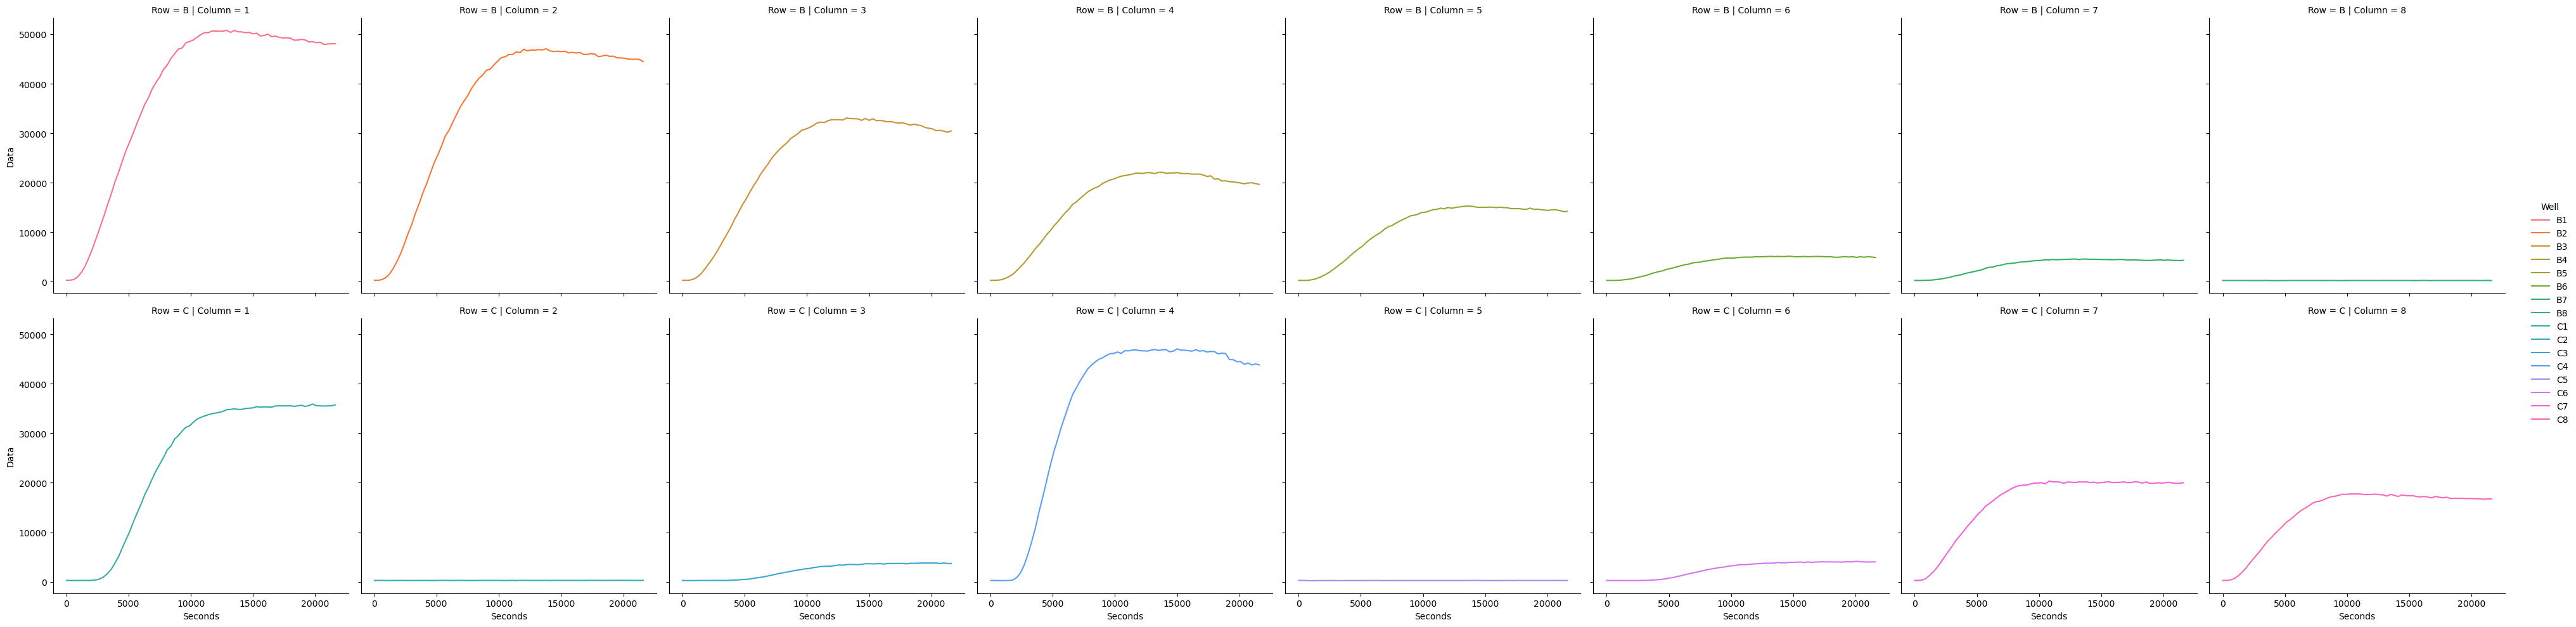

In [34]:
#| label: plt:expression-panel

plt = sns.relplot(
    data=data,
    x="Seconds",
    y="Data",
    hue="Well",
    row="Row",
    col="Column",
    kind="line"
);

## DNA Concentration Sweep

Here, we just want to pull out the experiments corresponding to the DNA concentration experiment

In [37]:
data_concentration = data[data["Experiment"] == "DNA Concentration"]

''

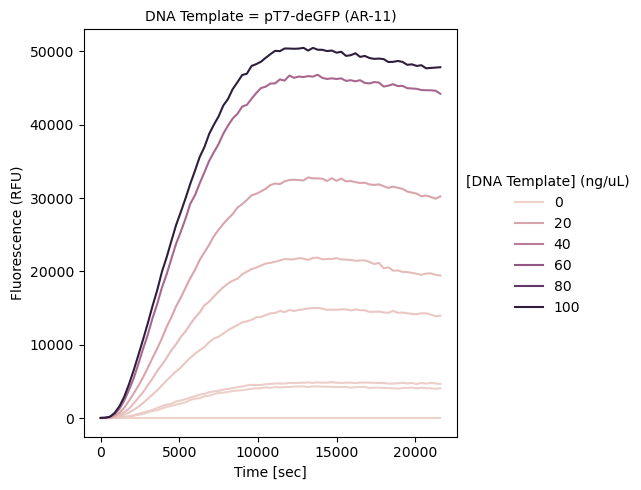

In [38]:
#| label: plt:expression-kinetics-simple

g = sns.relplot(
    data=data_concentration,
    x="Seconds",
    y="DataBlanked",
    hue="[DNA Template] (ng/uL)",
    col="DNA Template",
    kind="line",
    height=5,
    aspect=1
)
g.set_ylabels("Fluorescence (RFU)")
g.set_xlabels("Time [sec]")

for ax in g.axes.flat:
    ax.spines['top'].set_visible(True)   # Show top frame
    ax.spines['right'].set_visible(True) # Show right frame
    ax.spines['left'].set_visible(True)  # Ensure left frame is visible
    ax.spines['bottom'].set_visible(True)
;



### Kinetics

In [27]:
def sigmoid(x, L, k, x0):
    return (L / (1 + np.exp(-k*(x-x0))))

def kinetic_analysis_per_well(
    data: pd.DataFrame, 
    data_column="Data"
) -> pd.DataFrame:
    
    # make initial guesses for parameters
    L_initial = np.max(data[data_column])
    x0_initial = np.max(data["Seconds"]) / 4
    k_initial = (np.log(L_initial * 1.1 / data[data_column] - 1) / (data["Seconds"] - x0_initial)).dropna().mean() * -1.0
    p0 = [L_initial, k_initial, x0_initial]

    # attempt fitting
    try:
        params, _ = curve_fit(sigmoid, data["Seconds"], data[data_column], p0=p0)

        # Get the fitted curve
        x_fit = data["Seconds"]
        y_fit = sigmoid(x_fit, *params)

        # calculate velocities and velocity params
        v = data[data_column].diff(3) / data["Seconds"].diff(3)
        maxV = v.max()
        maxV_d = data.loc[v.idxmax(), data_column]
        maxV_s = data.loc[v.idxmax(), "Seconds"]

        # calculate lag time
        lag = -maxV_d / maxV + maxV_s

        decile_upper = data[data_column].quantile(0.95)
        decile_lower = data[data_column].quantile(0.05)

        growth_s = (decile_upper - maxV_d) / maxV + maxV_s

        ss_s = data.loc[(data[data_column] > decile_upper).idxmax(), "Seconds"]
        ss_d = data.loc[(data[data_column] > decile_upper).idxmax():, data_column].mean()

        kinetics = {
            f"{data_column}_fit_d": y_fit,
            f"{data_column}_maxV": maxV,
            f"{data_column}_maxV_s": maxV_s,
            f"{data_column}_maxV_d": maxV_d,
            f"{data_column}_lag_s": lag,
            f"{data_column}_growth_s": growth_s,
            f"{data_column}_ss_s": ss_s,
            f"{data_column}_ss_d": ss_d,
            f"{data_column}_low_d": decile_lower,
            f"{data_column}_high_d": decile_upper,
        }

        return pd.concat([data, pd.DataFrame(kinetics)], axis=1) 
        # return kinetics

    # if Exception raised, exit gracefully(ish)
    except Exception as e:
        print(f"Failed to solve:")
        print(e)
        
        return None

def kinetic_analysis(
    data: pd.DataFrame, 
    data_column="Data",
    time_cutoff: int = 12000
) -> pd.DataFrame:
    
    tk = (
        data[(data["Seconds"] < time_cutoff) & (data["Blank"].isna())]
        .groupby(["Well"])
        .apply(
            partial(kinetic_analysis_per_well, data_column=data_column)
        )
        .reset_index(drop=True)
    )
    return tk

def kinetic_analysis_summary(
    data: pd.DataFrame,
    data_column="Data",
    time_cutoff: int = 12000,
    label_order: list[str] = None,
):
    def per_well_cleanup(df):
        cols = df.columns
        return df[["Well"] + list(cols[27:])].aggregate(lambda x: x.iloc[0])
        
    tk = kinetic_analysis(data=data, data_column=data_column, time_cutoff=time_cutoff)
    out = tk.groupby("Well").apply(per_well_cleanup).reset_index(drop=True)

    if label_order:
        out = out.set_index("Well").reindex(label_order).reset_index()
    
    return out

def plot_kinetics(
    data: pd.DataFrame, 
    x: str ="Seconds", y: str ="Data", 
    show_fit: bool = False, show_velocity: bool = False, annotate: bool = False, 
    **kwargs
):
    """
    Typical usage:
    
    > tk = kinetic_analysis(data=data, data_column="BackgroundSubtracted")
    > g = sns.FacetGrid(tk, col="Well", col_wrap=2, sharey=False, height=4, aspect=1.5)
    > g.map_dataframe(plot_kinetics, show_fit=True, show_velocity=True)
    """
    colors = sns.color_palette("Set2")

    summary = data.iloc[0]
    
    ax = sns.scatterplot(
        data=data, 
        x=x, 
        y=y,
        alpha=0.5
    )

    ax_ylim = ax.get_ylim() # Use this to run lines to bounds later, then restore them before returning.

    if show_fit:
        sns.lineplot(
            data = data,
            x = x,
            y = y,
            linestyle = "--",
            c = "red",
            alpha=0.5
        )

    # Max Velocity
    maxV_x = np.linspace(data[x].min(), data[x].max(), 100)
    maxV_y = summary[f"{y}_maxV"] * (maxV_x - summary[f"{y}_maxV_s"]) + summary[f"{y}_maxV_d"]

    sns.lineplot(
        x = maxV_x[(maxV_y > 0) & (maxV_y < data[y].max())],
        y = maxV_y[(maxV_y > 0) & (maxV_y < data[y].max())],
        linestyle="--",
        c="r",
        ax=ax
    )

    maxV = summary[f"{y}_maxV"]
    maxV_s = summary[f"{y}_maxV_s"]
    maxV_d = summary[f"{y}_maxV_d"]

    # Lag Time
    lag = summary[f"{y}_lag_s"]
    decile_upper = summary[f"{y}_high_d"]
    decile_lower = summary[f"{y}_low_d"]
    ax.vlines(lag, ymin=ax_ylim[0], ymax=decile_lower, colors=colors[2], linestyle="--")

    # Time to Steady State
    ss_s = summary[f"{y}_ss_s"]
    ax.axvline(ss_s, c=colors[3], linestyle="--")

    # Range
    ax.axhline(decile_upper, c=colors[7], linestyle="--")
    ax.axhline(decile_lower, c=colors[7], linestyle="--")

    if annotate:
        # Plot the text annotations on the chart
        ax.annotate(f"$V_{{max}} = {maxV:.2f} u/s$", (maxV_s, maxV_d), xytext=(24,0), textcoords="offset points", arrowprops={"arrowstyle": "->"}, ha="left", va="center", c="black")
        ax.annotate(f"$t_{{lag}} = {lag:.0f}$ s", (lag, decile_lower), xytext=(12, 0), textcoords="offset points", ha="left", va="center")
        ax.annotate(f"$t_{{steady state}} = {ss_s - lag:.0f}$ s", (lag + (ss_s - lag)/4, decile_upper), xytext=(0, -12), textcoords="offset points", ha="center")

    # Velocity
    if show_velocity:
        # Show a velocity sparkline over the plot
        velocity = data.transform({y: "diff", x: lambda x: x}).rolling(5).mean()
        velocity[y] = velocity[y]
        # velocity_ax = ax.secondary_yaxis(location="right", functions=(lambda x: pd.Series(x).rolling(5).mean().values, lambda x: x))
        velocity_ax = ax.twinx()
        sns.lineplot(
            data=velocity, 
            x=x, 
            y=y,
            alpha=0.5,
            ax=velocity_ax
        )
        velocity_ax.set_ylabel("$V (u/s)$")
        velocity_ax.set_ylim((0, velocity[y].max()*2))

    ax.set_ylim(ax_ylim)

/var/folders/wx/177yjxbx7r3g3_xsj8945yvc0000gn/T/ipykernel_84516/2041100202.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


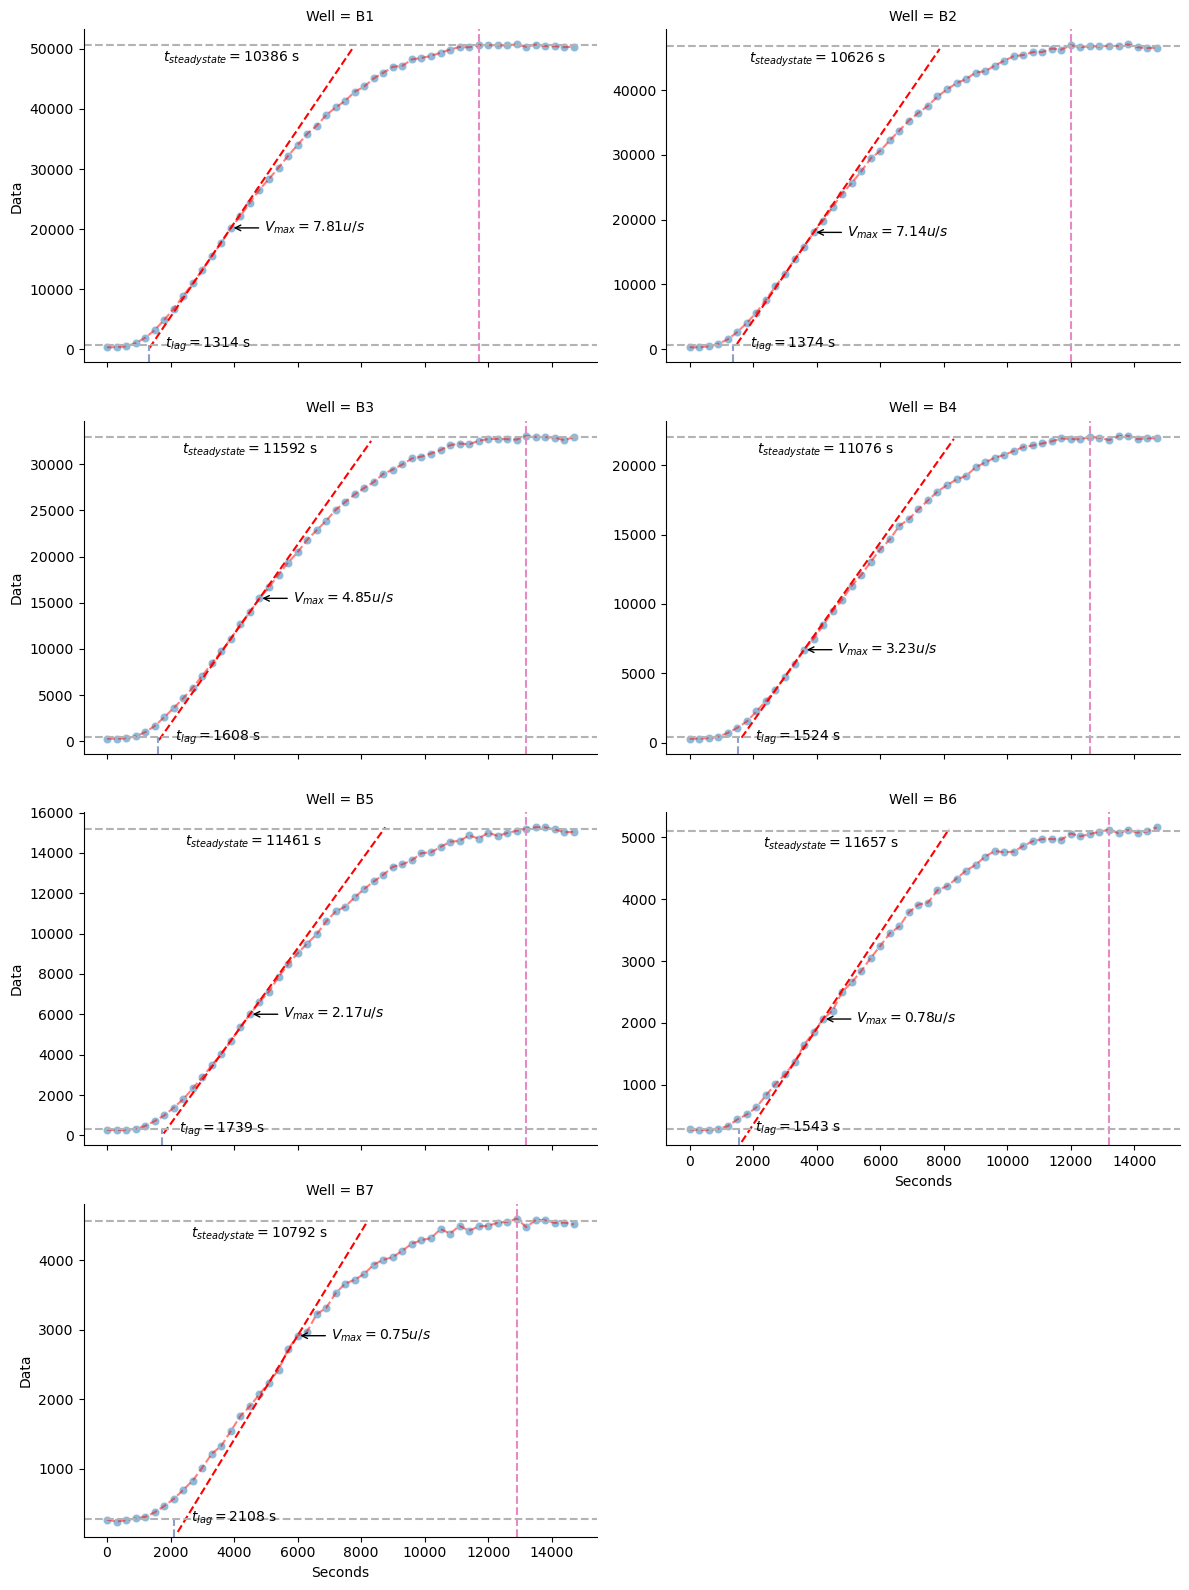

In [71]:
kinetics = kinetic_analysis(data=data_concentration, data_column="Data", time_cutoff=15000)

g = sns.FacetGrid(kinetics, col="Well", col_wrap=2, sharey=False, height=4, aspect=1.5)
g.map_dataframe(plot_kinetics, y="Data", show_fit=True, show_velocity=False, annotate=True)

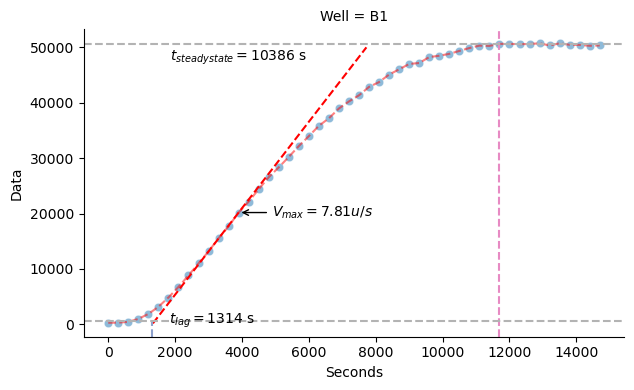

In [93]:
#| label: plt:single-kinetics

import warnings

tmp = data_concentration[data_concentration["Well"] == "B1"]
tmp
# tmp["Data"]
tmp2 = kinetic_analysis(data=tmp, data_column="Data", time_cutoff=15000)
g = sns.FacetGrid(tmp2, col="Well", col_wrap=2, sharey=False, height=4, aspect=1.5)
g.map_dataframe(plot_kinetics, y="Data", show_fit=True, show_velocity=False, annotate=True)

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")